 # World University Rankings

**Nomes:** Daniel, Davi, Eduardo, João

**Matriculas:**

 ## Introdução


(Introdução com Motivação e Pergunta de Pesquisa)




#### Perguntas

1 - H0 - A proporção de estudantes internacionais impacta no ranking da universidade        (Intervalo de confiança)

2 - H0 - Universidades mais disputadas (com menos alunos) possuem classificações melhores    (Intervalo de confiança)

    |-> Se influencia, temos como prever a pontuação final da universidade dado o número de alunos?    (Regressão)
    
3 - Detectar se a proporção entre homens e mulheres teve uma tendencia geral ao longo do tempo

4 - Podemos prever a posição/pontuação média das universidades de um país dado o seu investimento em educação? (Regressão)

## Metodologia

(Descreva sua base)

## Quais métodos e modelos foram utilizados.

(Justifique os mesmos.)

## Resultados
(análise exploratória)
(Testes de hipótese podem vir aqui.)


In [2]:
from scipy import stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

### TimesData

Primeiramente, importamos e analisamos os dados como estão sendo mostrados.

In [3]:
timesData = pd.read_csv("timesData.csv")

In [4]:
timesData.describe()

,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


In [5]:
timesData.head(3)


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011


### Tipos de dados

Separamos os tipos de dados para facilitar a exploração dos dados futuramente.

$$ Numeral $$

Discreto | Continuo
:--------- | -------:
world_rank | teaching
num_students |international
year |research
  |citations
  |income
  |total_score
  |student_staff_ratio
  |international_students
  |female_male_ratio



$$ Categorico $$

Categorico | Ordinal
:--------- | -------:
university_name	 | 
country	 | 



Verificamos a quantidade de valores nulos na tabela.

In [6]:
timesData.isna().sum()

world_rank                  0
university_name             0
country                     0
teaching                    0
international               0
research                    0
citations                   0
income                      0
total_score                 0
num_students               59
student_staff_ratio        59
international_students     67
female_male_ratio         233
year                        0
dtype: int64

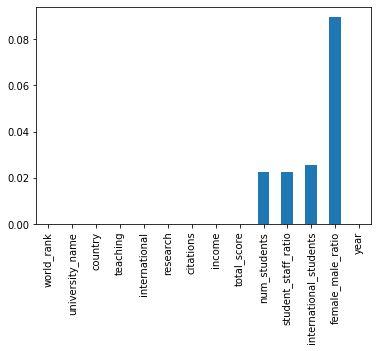

In [7]:
timesDataNaN = timesData.isna().sum()
timesDataNaN = timesDataNaN/len(timesData)
timesDataNaN.plot(kind='bar')

### Tratamento de Dados da timesData

In [8]:
def defineFemaleRatio(df):
    """
    Altera a coluna female_male_ratio para que mostre apenas a porcentagem de mulheres na universidade.
    Além disso, remove valores iguais a "-" e os salva como NaN.
    Dessa forma, fica mais fácil de analisar essa coluna. Retorna um novo dataframe sem alterar o df passado
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(df))
    for i in range(len(dfNovo)):
        if (not pd.isna(dfNovo.iloc[i,12])):
            if dfNovo.at[i,'female_male_ratio'] == '-':
                dfNovo.at[i,'female_male_ratio'] = np.nan
            else:
                dfNovo.at[i,'female_male_ratio'] = int(dfNovo.at[i,'female_male_ratio'].strip()[0:2])
    return dfNovo
            
def retiraPorcentagem(df):
    """
    Retira o símbolo de % da coluna 'international_students' e retorna um novo dataset sem modificar o original.
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        if (not pd.isna(dfNovo.iloc[i,11])):
            valorNovo = dfNovo.at[i,'international_students']
            if '%' in valorNovo:
                valorNovo = valorNovo[:-1]
            if valorNovo.strip() not in ['']:
                dfNovo.at[i,'international_students'] = int(valorNovo)
    return dfNovo

def retiraVirgulaNumAlunos(df):
    """
    df: Um dataframe
    Retira a vírgula que separa os números da coluna num_students e os converte para inteiro para que
    possam ser usados como dados em plots. Não altera o dataframe passado. Retorna um novo dataframe
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        if(not pd.isna(df.at[i,'num_students'])):
            dfNovo.at[i,'num_students'] = int(dfNovo.at[i,'num_students'].replace(',','',1))
    return dfNovo

def isFloat(value):
    """
    Retorna True se é possível converter o valor para float e False caso não seja possível
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

def calculaTotalScore(linha):
    """
    linha: Um objeto Series contendo as seguintes colunas:
        teaching, international, research, citations, income e year
        
    Retorna o total_score (arredondado com 1 casa decimal) de uma universidade de acordo
    com as regras da Times. 
    Retorna -1 caso o valor em 'year' não esteja da faixa de (2011-2016) ou caso pelo menos uma das cinco
    categorias não tenha um valor float
    
    O peso de cada categoria varia por ano:
    
        2011:
            peso_teaching: 30%
            peso_income: 2.5%
            peso_citations: 32.5%
            peso_research: 30%
            peso_international: 5%
            
        2012,2013,2014,2015,2016:
            peso_teaching: 30%
            peso_income: 2.5%
            peso_citations: 30%
            peso_research: 30%
            peso_international: 7.5%
         
        total_score = {(teaching*peso_teaching) + (international * peso_international) +
                        (income * peso_income) + (citations * peso_citations) + 
                        (research * peso_research)}/(100)
    
    """
    peso_teaching = 30
    peso_income = 2.5
    peso_citations = 0
    peso_research = 30
    peso_international = 0
    teaching = 0
    income = 0
    citations = 0
    research = 0
    international = 0
    
    if(isFloat(linha['teaching'])):
        teaching = float(linha['teaching'])
    else:
        return -1.0
    
    if(isFloat(linha['income'])):
        income = float(linha['income'])
    else:
        return -1.0
    
    if(isFloat(linha['citations'])):
        citations = float(linha['citations'])
    else:
        return -1.0
    
    if(isFloat(linha['research'])):
        research = float(linha['research'])
    else:
        return -1.0
    
    if(isFloat(linha['international'])):
        international = float(linha['international'])
    else:
        return -1.0
    
    if int(linha['year']) == 2011:
        peso_citations = 32.5
        peso_international = 5
    elif int(linha['year']) in [2012,2013,2014,2015,2016]:
        peso_citations = 30
        peso_international = 7.5
    else:
        return -1.0
    
    total_score = ((teaching*peso_teaching) + (international * peso_international) +
                        (income * peso_income) + (citations * peso_citations) + 
                        (research * peso_research))/(100)
    return float(round(total_score,1))

def completaTotalScores(df):
    """
    df: Um dataframe
    Calcula a nota final de cada universidade se for possível. Caso não seja possível, -1 é colocado como nota.
    Retorna um novo dataframe sem alterar o df passado
    """
    dfNovo = df.copy()
    dfNovo.index = range(len(dfNovo))
    for i in range(len(dfNovo)):
        novaNota = 0
        novaNota = calculaTotalScore(dfNovo.iloc[i])
        dfNovo.at[i,'total_score'] = novaNota
    for i in range(len(dfNovo)): #Onde total score é -1, foi feita uma média cm seu anterior e posterior#
        if dfNovo.at[i,'total_score'] == -1:
            notaMaior = float(dfNovo.at[i - 1,'total_score']) 
            notaMenor = float(dfNovo.at[i + 1,'total_score'])
            novaNota = (notaMaior + notaMenor)/2
            dfNovo.at[i,'total_score'] = novaNota
    return dfNovo

def arrumaNomePaises(df):
    """
    Arruma o nome de células que estão com:
    'Unisted States of America' para 'United States of America'
    'Unted Kingdom' para 'United Kingdom'
    """
    dfNovo = df.copy()

    #Index de quem tem o nome 'Unisted States of America'
    idxEUA = dfNovo.index[dfNovo['country'] == 'Unisted States of America']
    for i in range(len(idxEUA)):
        dfNovo.at[idxEUA[i],'country'] = 'United States of America'
    
    #Index de quem tem o nome 'Unted Kingdom'
    idxUK = dfNovo.index[dfNovo['country'] == 'Unted Kingdom']
    for i in range(len(idxUK)):
        dfNovo.at[idxUK[i],'country'] = 'United Kingdom'
    return dfNovo

def trataDadosTimes(df):
    """
    df: Um dataframe, de preferência, o dataset da times original.
    Trata os dados do dataset de acordo com todas as regras existentes que devem ser aplicadas até agora.
    Retorna um novo dataframe sem alterar o original.
    """
    dfNovo = completaTotalScores(df)
    dfNovo = retiraPorcentagem(dfNovo)
    dfNovo = retiraVirgulaNumAlunos(dfNovo)
    dfNovo = defineFemaleRatio(dfNovo)
    dfNovo = arrumaNomePaises(dfNovo)
    return dfNovo

In [9]:
#Tratando os dados da times
timesCompleto = trataDadosTimes(timesData)

In [10]:
timesCompleto.describe()

,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


In [11]:
timesCompleto.head(3)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152,8.9,25,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96,2243,6.9,27,33,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.5,11074,9.0,33,37,2011


Com o tratamento da timesData completo, podemos partir para analisar as proximas tabelas do nosso dataset.

### PibPaises

Foi usado o dataset de PIB de todos paises, pois tinhamos dados suplementares que continham a porcentagem do PIB de cada país gasto em educação.

In [12]:
pibPaises = pd.read_csv("pibPaises.csv")

In [13]:
pibPaises.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10,NaN,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10,NaN,NaN


In [14]:
pibPaises1 = pibPaises.iloc[:,55:61]
NomesPaises = pibPaises.iloc[:,0]
pibPaises1 = pibPaises1/1000000000 #PIB em bilhões de dólares#
pibPaisesCompleto = pd.concat([NomesPaises, pibPaises1], axis=1)

In [15]:
pibPaisesCompleto.head(3)

,Country Name,2011,2012,2013,2014,2015,2016
0,Aruba,2.549721,2.534637,2.701676,2.765363,2.919553,2.965922
1,Afghanistan,17.804293,20.001599,20.561070,20.484885,19.907111,18.017749
2,Angola,111.789686,128.052854,136.709863,145.712200,116.193649,101.123851


### exData

Tabela que contêm porcentagem de gastos do PIB de cada país com educação.

In [16]:
exData = pd.read_csv("education_expenditure_supplementary_data.csv")

In [17]:
exTotal = exData.iloc[223:,np.r_ [0,11:17]]
exTotal.reset_index(drop=True, inplace=True)
exTotal.head(3)

,country,2011,2012,2013,2014,2015,2016
0,Australia,5.8,5.6,5.6,5.7,6.0,5.8
1,Austria,5.7,4.9,5.0,4.9,4.9,4.9
2,Belgium,6.6,5.9,5.8,5.8,5.8,5.7


União das duas tabelas para saber o valor exato gasto em bilhões com educação.

In [18]:
investimentoPIB = pibPaisesCompleto.merge(exTotal,
        how = "inner",
        left_on = "Country Name", right_on = "country")
investimentoPIB = investimentoPIB.drop_duplicates(subset=['Country Name'], keep='last')
investimentoPIB.reset_index(drop=True, inplace=True)
investimentoPIB.head(3)

,Country Name,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,country,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y
0,Australia,1396.649906,1546.151784,1576.184467,1467.483705,1351.693985,1208.846994,Australia,1.6,1.6,1.7,1.8,2.1,2.0
1,Austria,431.120310,409.425234,430.068713,441.996132,381.817566,395.568644,Austria,1.5,1.7,1.7,1.7,1.7,1.7
2,Belgium,522.645519,496.181260,521.642714,534.678076,462.149679,475.739589,Belgium,1.4,1.4,1.4,1.4,1.4,1.4


### Tratamento de Dados
Foi feito o tratamento de dados da junção das duas tabelas

In [19]:
investimentoPIB.rename(columns={"Country Name": "country"})
investimentoPIB.country.unique()

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada',
       'Switzerland', 'Chile', 'Czech Republic', 'Germany', 'Denmark',
       'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom',
       'Greece', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy',
       'Japan', 'Luxembourg', 'Mexico', 'Netherlands', 'Norway',
       'New Zealand', 'Poland', 'Portugal', 'Russian Federation',
       'Slovak Republic', 'Slovenia', 'Sweden', 'Turkey', 'United States'],
      dtype=object)

In [20]:
investimentoPIB['Result2012'] = investimentoPIB['2012_x']*investimentoPIB['2012_y']/100
investimentoPIB['Result2013'] = investimentoPIB['2013_x']*investimentoPIB['2013_y']/100
investimentoPIB['Result2014'] = investimentoPIB['2014_x']*investimentoPIB['2014_y']/100
investimentoPIB['Result2015'] = investimentoPIB['2015_x']*investimentoPIB['2015_y']/100
investimentoPIB['Result2016'] = investimentoPIB['2016_x']*investimentoPIB['2016_y']/100

Tratamento da junção das duas tabelas completo

In [21]:
investimentoEducacao = investimentoPIB.iloc[:,np.r_ [0,14:19]]
investimentoEducacao

,Country Name,Result2012,Result2013,Result2014,Result2015,Result2016
0,Australia,24.738429,26.795136,26.414707,28.385574,24.176940
1,Austria,6.960229,7.311168,7.513934,6.490899,6.724667
2,Belgium,6.946538,7.302998,7.485493,6.470096,6.660354
3,Brazil,22.186698,22.255262,19.647949,NaN,NaN
4,Canada,0.000000,0.000000,46.891863,37.347109,35.149594
5,Switzerland,8.016523,8.262050,9.219373,8.837820,8.727020
6,Chile,6.678058,6.681224,6.252999,4.878382,6.261003
7,Czech Republic,2.924008,2.751913,2.512306,1.880331,1.766449
8,Germany,42.328139,44.792921,50.490962,40.274828,41.609976
9,Denmark,0.000000,5.840935,6.000892,0.000000,0.000000


In [22]:
investimentoEducacao.describe()

,Result2012,Result2013,Result2014,Result2015,Result2016
count,35.000000,35.000000,35.000000,34.000000,34.000000
mean,26.031835,26.042688,27.881648,26.170497,25.786177
std,76.732106,73.596319,76.633479,80.633149,79.691845
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.120850,2.807218,3.028769,1.958361,1.892123
50%,6.946538,7.302998,7.513934,6.480497,6.692511
75%,17.799477,19.512500,19.689108,16.188748,14.951013
max,453.516206,436.406079,455.706256,473.842315,467.874013


In [23]:
investimentoEducacao.isna().sum()

Country Name    0
Result2012      0
Result2013      0
Result2014      0
Result2015      1
Result2016      1
dtype: int64

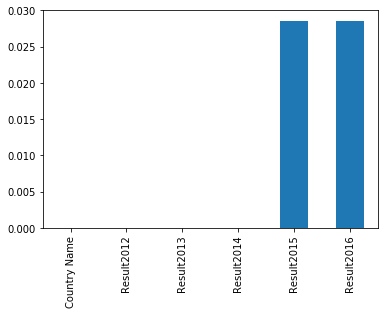

In [24]:
investimentoEducacaoNaN = investimentoEducacao.isna().sum()
investimentoEducacaoNaN = investimentoEducacaoNaN/len(investimentoEducacao)
investimentoEducacaoNaN.plot(kind='bar')

### Tipos de dados

Separamos os tipos de dados para facilitar a exploração dos dados futuramente.

$$ Numeral $$

Discreto | Continuo
:--------- | -------:
 | Result2011	a Result2016	

$$ Categorico $$

Categorico | Ordinal
:--------- | -------:
Country Name | 

...

Descobrir o total_score de cada pais usando a media total das universidades e usando cada ano especifico

Fazer um grafico scatter total_score 







In [25]:
timesCompleto[timesCompleto['world_rank']=='1'][['university_name', 'country', 'total_score','year']]

,university_name,country,total_score,year
0,Harvard University,United States of America,96.1,2011
200,California Institute of Technology,United States of America,94.8,2012
602,California Institute of Technology,United States of America,95.5,2013
1002,California Institute of Technology,United States of America,94.9,2014
1402,California Institute of Technology,United States of America,94.3,2015
1803,California Institute of Technology,United States of America,95.1,2016


In [26]:
timesTratado2012=timesCompleto[timesCompleto['year']==2012][['university_name', 'country', 'total_score','year']]

timesTratado2013=timesCompleto[timesCompleto['year']==2013][['university_name', 'country', 'total_score','year']]

timesTratado2014=timesCompleto[timesCompleto['year']==2014][['university_name', 'country', 'total_score','year']]

timesTratado2015=timesCompleto[timesCompleto['year']==2015][['university_name', 'country', 'total_score','year']]

timesTratado2016=timesCompleto[timesCompleto['year']==2016][['university_name', 'country', 'total_score','year']]

In [27]:
timesTratado2012['sum'] = timesTratado2012.groupby(['country'])['total_score'].transform('sum')
timesTratado2012['count'] = timesTratado2012.groupby(['country'])['total_score'].transform('count')
timesTratado2012['media'] = timesTratado2012['sum'] / timesTratado2012['count']
MediaNotaPais2012 = timesTratado2012.drop_duplicates(subset=['country'])[['country','media']].sort_values(by="country").copy()

timesTratado2013['sum'] = timesTratado2013.groupby(['country'])['total_score'].transform('sum')
timesTratado2013['count'] = timesTratado2013.groupby(['country'])['total_score'].transform('count')
timesTratado2013['media'] = timesTratado2013['sum'] / timesTratado2013['count']
MediaNotaPais2013 = timesTratado2013.drop_duplicates(subset=['country'])[['country','media']].sort_values(by="country").copy()

timesTratado2014['sum'] = timesTratado2014.groupby(['country'])['total_score'].transform('sum')
timesTratado2014['count'] = timesTratado2014.groupby(['country'])['total_score'].transform('count')
timesTratado2014['media'] = timesTratado2014['sum'] / timesTratado2014['count']
MediaNotaPais2014 = timesTratado2014.drop_duplicates(subset=['country'])[['country','media']].sort_values(by="country").copy()

timesTratado2015['sum'] = timesTratado2015.groupby(['country'])['total_score'].transform('sum')
timesTratado2015['count'] = timesTratado2015.groupby(['country'])['total_score'].transform('count')
timesTratado2015['media'] = timesTratado2015['sum'] / timesTratado2015['count']
MediaNotaPais2015= timesTratado2015.drop_duplicates(subset=['country'])[['country','media']].sort_values(by="country").copy()

timesTratado2016['sum'] = timesTratado2016.groupby(['country'])['total_score'].transform('sum')
timesTratado2016['count'] = timesTratado2016.groupby(['country'])['total_score'].transform('count')
timesTratado2016['media'] = timesTratado2016['sum'] / timesTratado2016['count']
MediaNotaPais2016 = timesTratado2016.drop_duplicates(subset=['country'])[['country','media']].sort_values(by="country").copy()

MediaNotaPais2012.rename(columns={ MediaNotaPais2012.columns[1]: "2012" }, inplace = True)
MediaNotaPais2013.rename(columns={ MediaNotaPais2013.columns[1]: "2013" }, inplace = True)
MediaNotaPais2014.rename(columns={ MediaNotaPais2014.columns[1]: "2014" }, inplace = True)
MediaNotaPais2015.rename(columns={ MediaNotaPais2015.columns[1]: "2015" }, inplace = True)
MediaNotaPais2016.rename(columns={ MediaNotaPais2016.columns[1]: "2016" }, inplace = True)

MediaNotaPais = MediaNotaPais2012.merge(MediaNotaPais2013,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais = MediaNotaPais.merge(MediaNotaPais2014,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais = MediaNotaPais.merge(MediaNotaPais2015,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais = MediaNotaPais.merge(MediaNotaPais2016,
        how = "inner",
        left_on = "country", right_on = "country")

MediaNotaPais




,country,2012,2013,2014,2015,2016
0,Australia,38.057143,45.931579,43.552632,45.675000,43.735484
1,Austria,36.040000,40.458333,38.500000,41.720000,40.771429
2,Belgium,41.457143,47.571429,46.842857,46.985714,50.200000
3,Brazil,38.400000,45.350000,37.900000,39.600000,21.795588
4,Canada,47.405556,49.760526,47.031579,49.722222,45.124000
5,China,37.910000,45.744444,42.760000,43.590909,27.963514
6,Czech Republic,30.800000,35.300000,32.500000,36.500000,25.833333
7,Denmark,40.760000,46.300000,44.080000,44.540000,49.950000
8,Finland,34.460000,38.880000,37.370000,38.900000,38.955556
9,France,46.275000,47.654167,47.890909,48.172727,37.159259


In [28]:
investimentoEducacao.rename(columns={ investimentoEducacao.columns[0]: "country" }, inplace = True)


Final = MediaNotaPais.merge(investimentoEducacao,
        how = "inner",
        left_on = "country", right_on = "country")
 
Final = Final.fillna(0) 

Final

,country,2012,2013,2014,2015,2016,Result2012,Result2013,Result2014,Result2015,Result2016
0,Australia,38.057143,45.931579,43.552632,45.675000,43.735484,24.738429,26.795136,26.414707,28.385574,24.176940
1,Austria,36.040000,40.458333,38.500000,41.720000,40.771429,6.960229,7.311168,7.513934,6.490899,6.724667
2,Belgium,41.457143,47.571429,46.842857,46.985714,50.200000,6.946538,7.302998,7.485493,6.470096,6.660354
3,Brazil,38.400000,45.350000,37.900000,39.600000,21.795588,22.186698,22.255262,19.647949,0.000000,0.000000
4,Canada,47.405556,49.760526,47.031579,49.722222,45.124000,0.000000,0.000000,46.891863,37.347109,35.149594
5,Czech Republic,30.800000,35.300000,32.500000,36.500000,25.833333,2.924008,2.751913,2.512306,1.880331,1.766449
6,Denmark,40.760000,46.300000,44.080000,44.540000,49.950000,0.000000,5.840935,6.000892,0.000000,0.000000
7,Finland,34.460000,38.880000,37.370000,38.900000,38.955556,4.907792,4.883135,4.940950,3.985481,3.849727
8,France,46.275000,47.654167,47.890909,48.172727,37.159259,40.257378,42.166166,42.782486,34.134911,34.597998
9,Germany,42.615909,46.916000,44.450000,46.075000,51.008108,42.328139,44.792921,50.490962,40.274828,41.609976


In [29]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [30]:
def sum_of_squared_errors(alpha, beta, x, y):
    return (error(alpha, beta, x, y) ** 2).sum()

def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

Text(0.5, 1.0, 'Comparativo investimento x nota 2012')

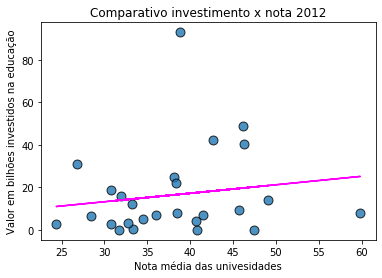

In [31]:
x = Final['2012'].values
y = Final['Result2012'].values
alpha, beta = least_squares_fit(x, y)
y1_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y1_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota 2012')

Text(0.5, 1.0, 'Comparativo investimento x nota 2013')

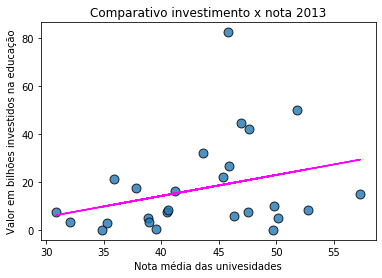

In [32]:
x = Final['2013'].values
y = Final['Result2013'].values
alpha, beta = least_squares_fit(x, y)
y2_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y2_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota 2013')

Text(0.5, 1.0, 'Comparativo investimento x nota 2014')

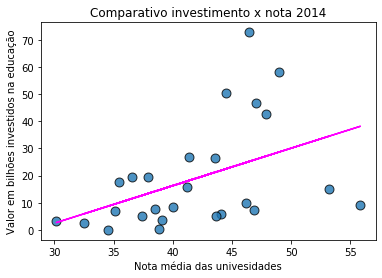

In [33]:
x = Final['2014'].values
y = Final['Result2014'].values
alpha, beta = least_squares_fit(x, y)
y3_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y3_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota 2014')

Text(0.5, 1.0, 'Comparativo investimento x nota 2015')

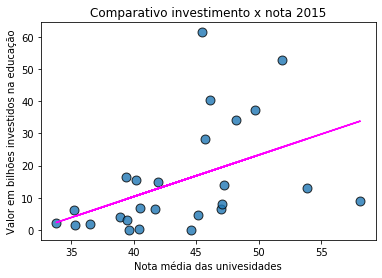

In [34]:
x = Final['2015'].values
y = Final['Result2015'].values
alpha, beta = least_squares_fit(x, y)
y4_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y4_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota 2015')

Text(0.5, 1.0, 'Comparativo investimento x nota 2016')

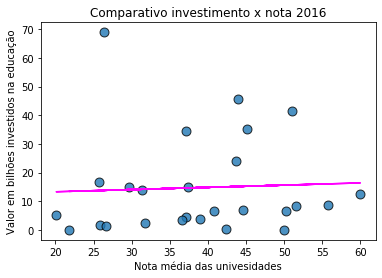

In [35]:
x = Final['2016'].values
y = Final['Result2016'].values
alpha, beta = least_squares_fit(x, y)
y5_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y5_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota 2016')

In [36]:
Final2012 = Final["2012"]
Final2013 = Final["2013"]
Final2014 = Final["2014"]
Final2015 = Final["2015"]
Final2016 = Final["2016"]

FinalMedia = pd.concat([Final2012, Final2013, Final2014, Final2015, Final2016], axis = 0)

FinalMedia.to_frame()

Final2012 = Final["Result2012"]
Final2013 = Final["Result2013"]
Final2014 = Final["Result2014"]
Final2015 = Final["Result2015"]
Final2016 = Final["Result2016"]

FinalInvestimento = pd.concat([Final2012, Final2013, Final2014, Final2015, Final2016], axis = 0)

FinalInvestimento.to_frame()

FinalTotal = pd.concat([FinalMedia, FinalInvestimento], axis = 1)

FinalTotal.rename(columns={FinalTotal.columns[0]: "Media", FinalTotal.columns[1]: "Investimento" }, inplace = True)

FinalTotal.head(3)

,Media,Investimento
0,38.057143,24.738429
1,36.040000,6.960229
2,41.457143,6.946538


Text(0.5, 1.0, 'Comparativo investimento x nota de 2012-2016')

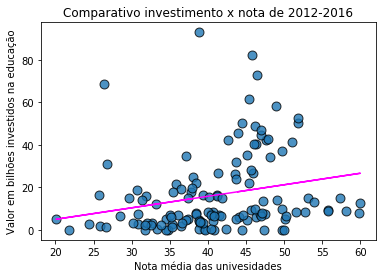

In [37]:
x = FinalTotal['Media'].values
y = FinalTotal['Investimento'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Nota média das univesidades')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota de 2012-2016')

In [38]:
Ex = beta * 40 + alpha 

Ex

15.811368116169174

In [39]:
beta,alpha

(0.5422270009612017, -5.877711922278895)

In [40]:
EUValues = Final[(Final["country"] == "Austria") | (Final["country"] == "Belgium") | (Final["country"] == "Czech Republic") | (Final["country"] == "Finland") | (Final["country"] == "France") |(Final["country"] == "Germany") | (Final["country"] == "Iceland") | (Final["country"] == "Italy") |(Final["country"] == "Netherlands") | (Final["country"] == "Norway") | (Final["country"] == "Poland") | (Final["country"] == "Portugal") | (Final["country"] == "Spain") | (Final["country"] == "Sweden") | (Final["country"] == "Switzerland") | (Final["country"] == "United Kingdom")]

EUValues.reset_index(drop=True, inplace=True)

EUValues

,country,2012,2013,2014,2015,2016,Result2012,Result2013,Result2014,Result2015,Result2016
0,Austria,36.040000,40.458333,38.500000,41.720000,40.771429,6.960229,7.311168,7.513934,6.490899,6.724667
1,Belgium,41.457143,47.571429,46.842857,46.985714,50.200000,6.946538,7.302998,7.485493,6.470096,6.660354
2,Czech Republic,30.800000,35.300000,32.500000,36.500000,25.833333,2.924008,2.751913,2.512306,1.880331,1.766449
3,Finland,34.460000,38.880000,37.370000,38.900000,38.955556,4.907792,4.883135,4.940950,3.985481,3.849727
4,France,46.275000,47.654167,47.890909,48.172727,37.159259,40.257378,42.166166,42.782486,34.134911,34.597998
5,Germany,42.615909,46.916000,44.450000,46.075000,51.008108,42.328139,44.792921,50.490962,40.274828,41.609976
6,Iceland,33.300000,39.500000,38.800000,40.400000,42.400000,0.176689,0.208436,0.230855,0.208669,0.247420
7,Italy,30.750000,35.885714,36.520000,39.400000,37.444118,18.783693,21.413153,19.432205,16.523093,15.006380
8,Netherlands,49.126923,57.323077,53.161538,53.884615,60.015385,14.262512,14.907700,15.146682,13.009504,12.536451
9,Norway,38.425000,40.625000,39.975000,40.475000,44.675000,8.152101,8.364185,8.472971,6.944428,7.007579


In [41]:
EUValues2012 = EUValues["2012"]
EUValues2013 = EUValues["2013"]
EUValues2014 = EUValues["2014"]
EUValues2015 = EUValues["2015"]
EUValues2016 = EUValues["2016"]

EUValuesMedia = pd.concat([EUValues2012, EUValues2013, EUValues2014, EUValues2015, EUValues2016], axis = 0)

EUValuesMedia.to_frame()

EUValues2012 = EUValues["Result2012"]
EUValues2013 = EUValues["Result2013"]
EUValues2014 = EUValues["Result2014"]
EUValues2015 = EUValues["Result2015"]
EUValues2016 = EUValues["Result2016"]

EUValuesInvestimento = pd.concat([EUValues2012, EUValues2013, EUValues2014, EUValues2015, EUValues2016], axis = 0)

EUValuesInvestimento.to_frame()

EUValuesTotal = pd.concat([EUValuesMedia, EUValuesInvestimento], axis = 1)

EUValuesTotal.rename(columns={EUValuesTotal.columns[0]: "Media", EUValuesTotal.columns[1]: "Investimento" }, inplace = True)

EUValuesTotal.head(3)

,Media,Investimento
0,36.040000,6.960229
1,41.457143,6.946538
2,30.800000,2.924008


Text(0.5, 1.0, 'Comparativo investimento x nota de 2012-2016 das universidades européias')

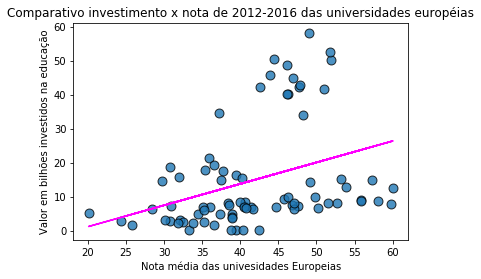

In [42]:
x = EUValuesTotal['Media'].values
y = EUValuesTotal['Investimento'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Nota média das univesidades Europeias')
plt.ylabel('Valor em bilhões investidos na educação')
plt.title('Comparativo investimento x nota de 2012-2016 das universidades européias')

In [43]:
Ex = beta * 40 + alpha 

Ex

13.837536254390745

### Pergunta 3

Detectar se a proporção entre homens e mulheres teve uma tendencia geral ao longo do tempo

In [44]:
timesCompleto.head(3)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152,8.9,25,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96,2243,6.9,27,33,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.5,11074,9.0,33,37,2011


In [51]:
Alunas = timesCompleto["female_male_ratio"]
Alunas = Alunas.to_frame()

Alunas.rename(columns={Alunas.columns[0]: "Porcentagem de alunas"}, inplace = True)

Alunos = 100 - Alunas

Alunos.rename(columns={Alunos.columns[0]: "Porcentagem de alunos"}, inplace = True)



In [52]:
ComQuantidadeAlunos = pd.concat([timesCompleto, Alunas, Alunos], axis=1)

ComQuantidadeAlunos.head(3)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year,Porcentagem de alunas,Porcentagem de alunos
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152,8.9,25,NaN,2011,NaN,NaN
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96,2243,6.9,27,33,2011,33,67
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.5,11074,9.0,33,37,2011,37,63


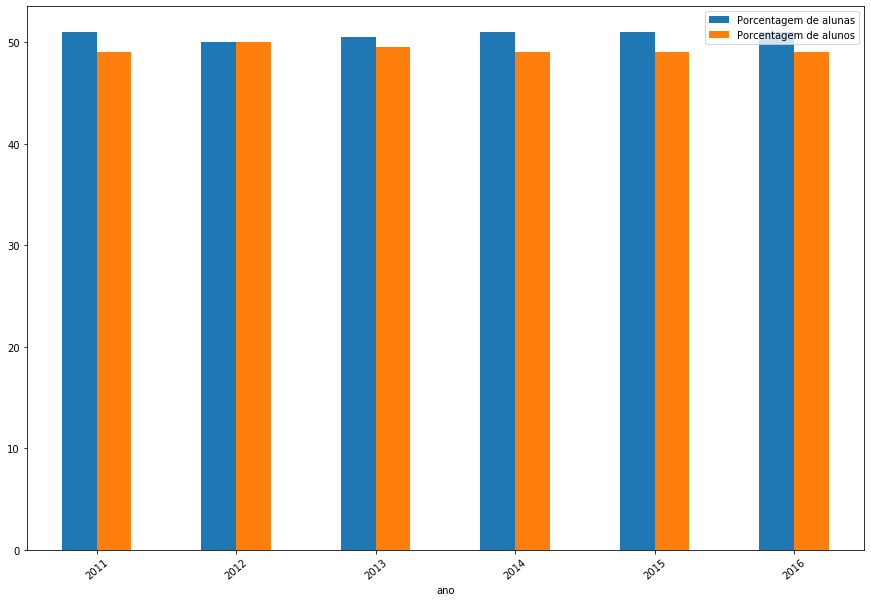

In [63]:
Us = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "United States of America"]

Us2011 = Us[Us["year"] == 2011]
UsAlunas2011 = Us2011['Porcentagem de alunas'].median()
UsAlunos2011 = Us2011['Porcentagem de alunos'].median()

Us2012 = Us[Us["year"] == 2012]
UsAlunas2012 = Us2012['Porcentagem de alunas'].median()
UsAlunos2012 = Us2012['Porcentagem de alunos'].median()

Us2013 = Us[Us["year"] == 2013]
UsAlunas2013 = Us2013['Porcentagem de alunas'].median()
UsAlunos2013 = Us2013['Porcentagem de alunos'].median()

Us2014 = Us[Us["year"] == 2014]
UsAlunas2014 = Us2014['Porcentagem de alunas'].median()
UsAlunos2014 = Us2014['Porcentagem de alunos'].median()

Us2015 = Us[Us["year"] == 2015]
UsAlunas2015 = Us2015['Porcentagem de alunas'].median()
UsAlunos2015 = Us2015['Porcentagem de alunos'].median()

Us2016 = Us[Us["year"] == 2016]
UsAlunas2016 = Us2016['Porcentagem de alunas'].median()
UsAlunos2016 = Us2016['Porcentagem de alunos'].median()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [UsAlunas2011, UsAlunas2012, UsAlunas2013, UsAlunas2014, UsAlunas2015, UsAlunas2016], 
     'Porcentagem de alunos' : [UsAlunos2011, UsAlunos2012, UsAlunos2013, UsAlunos2014, UsAlunos2015, UsAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

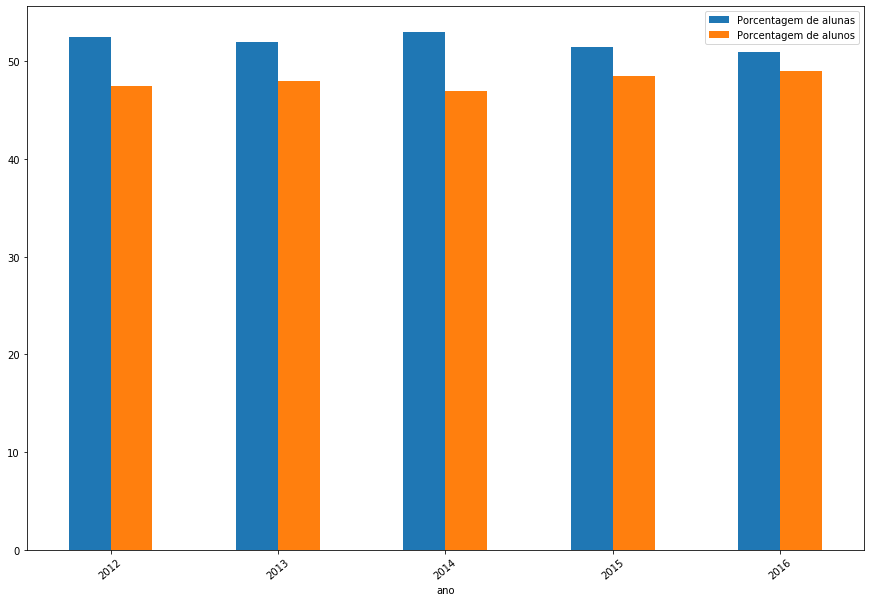

In [85]:
Pt = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Portugal"]

Pt2012 = Pt[Pt["year"] == 2012]
PtAlunas2012 = Pt2012['Porcentagem de alunas'].median()
PtAlunos2012 = Pt2012['Porcentagem de alunos'].median()

Pt2013 = Pt[Pt["year"] == 2013]
PtAlunas2013 = Pt2013['Porcentagem de alunas'].median()
PtAlunos2013 = Pt2013['Porcentagem de alunos'].median()

Pt2014 = Pt[Pt["year"] == 2014]
PtAlunas2014 = Pt2014['Porcentagem de alunas'].median()
PtAlunos2014 = Pt2014['Porcentagem de alunos'].median()

Pt2015 = Pt[Pt["year"] == 2015]
PtAlunas2015 = Pt2015['Porcentagem de alunas'].median()
PtAlunos2015 = Pt2015['Porcentagem de alunos'].median()

Pt2016 = Pt[Pt["year"] == 2016]
PtAlunas2016 = Pt2016['Porcentagem de alunas'].median()
PtAlunos2016 = Pt2016['Porcentagem de alunos'].median()

d = {'ano': [ 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [PtAlunas2012, PtAlunas2013, PtAlunas2014, PtAlunas2015, PtAlunas2016], 
     'Porcentagem de alunos' : [PtAlunos2012, PtAlunos2013, PtAlunos2014, PtAlunos2015, PtAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

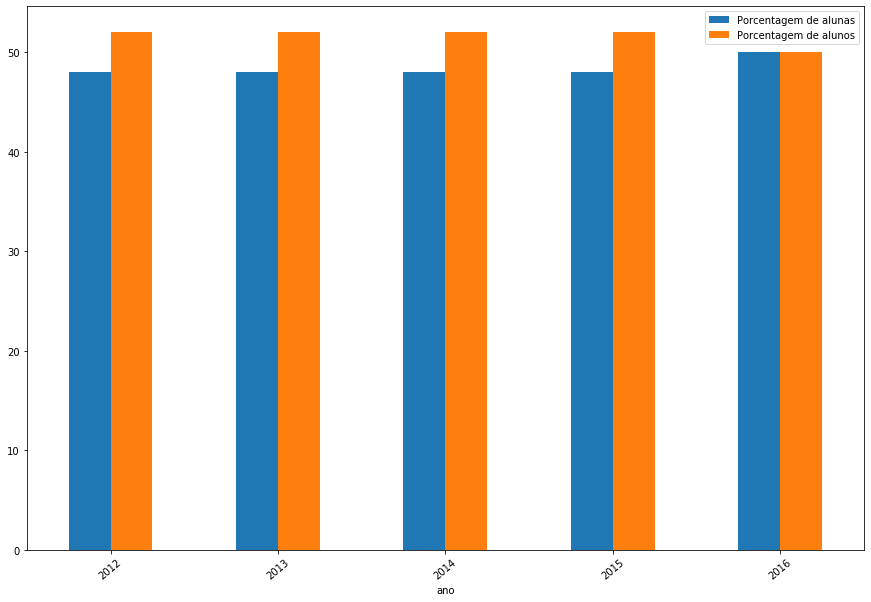

In [68]:
Br = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Brazil"]

Br2011 = Br[Br["year"] == 2011]
BrAlunas2011 = Br2011['Porcentagem de alunas'].median()
BrAlunos2011 = Br2011['Porcentagem de alunos'].median()

Br2012 = Br[Br["year"] == 2012]
BrAlunas2012 = Br2012['Porcentagem de alunas'].median()
BrAlunos2012 = Br2012['Porcentagem de alunos'].median()

Br2013 = Br[Br["year"] == 2013]
BrAlunas2013 = Br2013['Porcentagem de alunas'].median()
BrAlunos2013 = Br2013['Porcentagem de alunos'].median()

Br2014 = Br[Br["year"] == 2014]
BrAlunas2014 = Br2014['Porcentagem de alunas'].median()
BrAlunos2014 = Br2014['Porcentagem de alunos'].median()

Br2015 = Br[Br["year"] == 2015]
BrAlunas2015 = Br2015['Porcentagem de alunas'].median()
BrAlunos2015 = Br2015['Porcentagem de alunos'].median()

Br2016 = Br[Br["year"] == 2016]
BrAlunas2016 = Br2016['Porcentagem de alunas'].median()
BrAlunos2016 = Br2016['Porcentagem de alunos'].median()

d = {'ano': [2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [BrAlunas2012, BrAlunas2013, BrAlunas2014, BrAlunas2015, BrAlunas2016], 
     'Porcentagem de alunos' : [BrAlunos2012, BrAlunos2013, BrAlunos2014, BrAlunos2015, BrAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

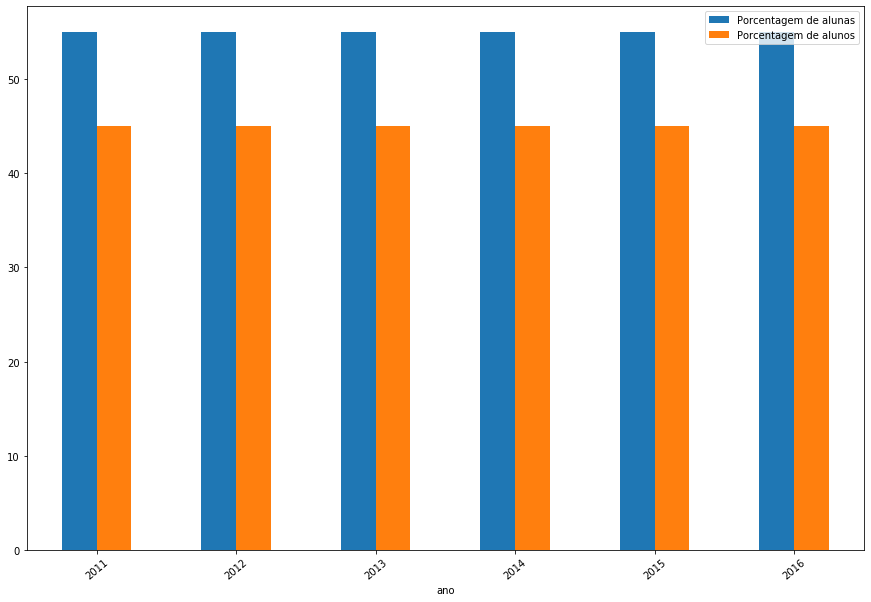

In [74]:
Ca = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Canada"]

Ca2011 = Ca[Ca["year"] == 2011]
CaAlunas2011 = Ca2011['Porcentagem de alunas'].median()
CaAlunos2011 = Ca2011['Porcentagem de alunos'].median()

Ca2012 = Ca[Ca["year"] == 2012]
CaAlunas2012 = Ca2012['Porcentagem de alunas'].median()
CaAlunos2012 = Ca2012['Porcentagem de alunos'].median()

Ca2013 = Ca[Ca["year"] == 2013]
CaAlunas2013 = Ca2013['Porcentagem de alunas'].median()
CaAlunos2013 = Ca2013['Porcentagem de alunos'].median()

Ca2014 = Ca[Ca["year"] == 2014]
CaAlunas2014 = Ca2014['Porcentagem de alunas'].median()
CaAlunos2014 = Ca2014['Porcentagem de alunos'].median()

Ca2015 = Ca[Ca["year"] == 2015]
CaAlunas2015 = Ca2015['Porcentagem de alunas'].median()
CaAlunos2015 = Ca2015['Porcentagem de alunos'].median()

Ca2016 = Ca[Ca["year"] == 2016]
CaAlunas2016 = Ca2016['Porcentagem de alunas'].median()
CaAlunos2016 = Ca2016['Porcentagem de alunos'].median()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [CaAlunas2011, CaAlunas2012, CaAlunas2013, CaAlunas2014, CaAlunas2015, CaAlunas2016], 
     'Porcentagem de alunos' : [CaAlunos2011, CaAlunos2012, CaAlunos2013, CaAlunos2014, CaAlunos2015, CaAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

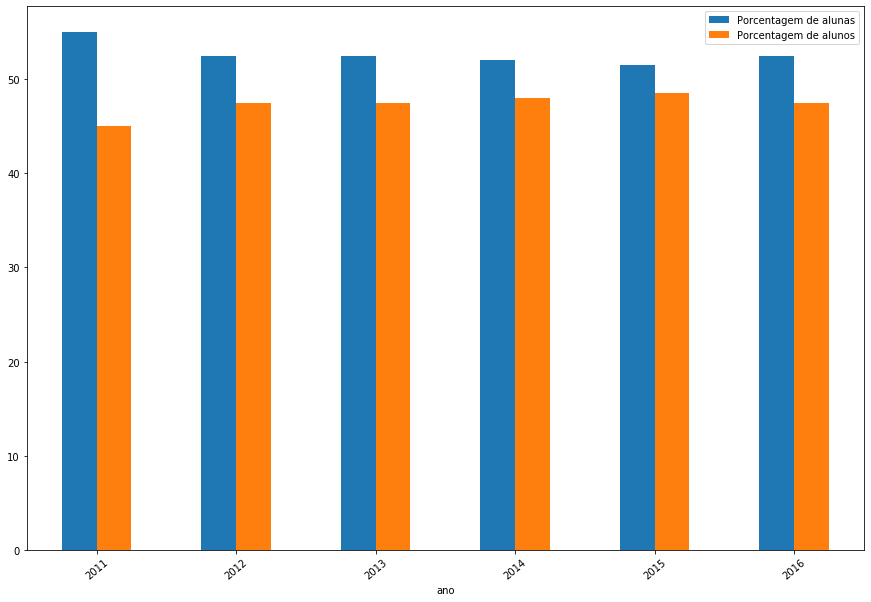

In [76]:
Ge = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Germany"]

Ge2011 = Ge[Ge["year"] == 2011]
GeAlunas2011 = Ge2011['Porcentagem de alunas'].median()
GeAlunos2011 = Ge2011['Porcentagem de alunos'].median()

Ge2012 = Ge[Ge["year"] == 2012]
GeAlunas2012 = Ge2012['Porcentagem de alunas'].median()
GeAlunos2012 = Ge2012['Porcentagem de alunos'].median()

Ge2013 = Ge[Ge["year"] == 2013]
GeAlunas2013 = Ge2013['Porcentagem de alunas'].median()
GeAlunos2013 = Ge2013['Porcentagem de alunos'].median()

Ge2014 = Ge[Ge["year"] == 2014]
GeAlunas2014 = Ge2014['Porcentagem de alunas'].median()
GeAlunos2014 = Ge2014['Porcentagem de alunos'].median()

Ge2015 = Ge[Ge["year"] == 2015]
GeAlunas2015 = Ge2015['Porcentagem de alunas'].median()
GeAlunos2015 = Ge2015['Porcentagem de alunos'].median()

Ge2016 = Ge[Ge["year"] == 2016]
GeAlunas2016 = Ge2016['Porcentagem de alunas'].median()
GeAlunos2016 = Ge2016['Porcentagem de alunos'].median()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [GeAlunas2011, GeAlunas2012, GeAlunas2013, GeAlunas2014, GeAlunas2015, GeAlunas2016], 
     'Porcentagem de alunos' : [GeAlunos2011, GeAlunos2012, GeAlunos2013, GeAlunos2014, GeAlunos2015, GeAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

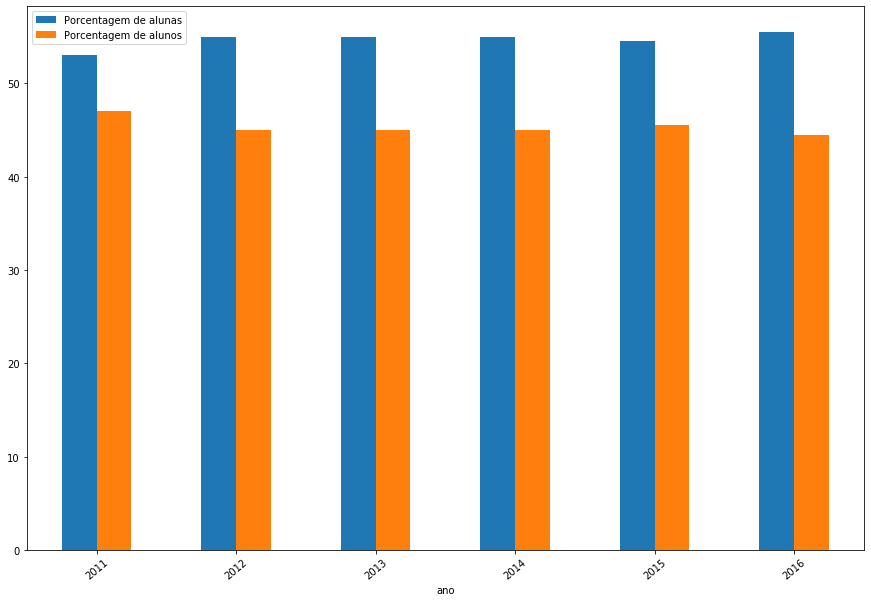

In [158]:
Au = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Australia"]

Au2011 = Au[Au["year"] == 2011]
AuAlunas2011 = Au2011['Porcentagem de alunas'].median()
AuAlunos2011 = Au2011['Porcentagem de alunos'].median()

Au2012 = Au[Au["year"] == 2012]
AuAlunas2012 = Au2012['Porcentagem de alunas'].median()
AuAlunos2012 = Au2012['Porcentagem de alunos'].median()

Au2013 = Au[Au["year"] == 2013]
AuAlunas2013 = Au2013['Porcentagem de alunas'].median()
AuAlunos2013 = Au2013['Porcentagem de alunos'].median()

Au2014 = Au[Au["year"] == 2014]
AuAlunas2014 = Au2014['Porcentagem de alunas'].median()
AuAlunos2014 = Au2014['Porcentagem de alunos'].median()

Au2015 = Au[Au["year"] == 2015]
AuAlunas2015 = Au2015['Porcentagem de alunas'].median()
AuAlunos2015 = Au2015['Porcentagem de alunos'].median()

Au2016 = Au[Au["year"] == 2016]
AuAlunas2016 = Au2016['Porcentagem de alunas'].median()
AuAlunos2016 = Au2016['Porcentagem de alunos'].median()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [AuAlunas2011, AuAlunas2012, AuAlunas2013, AuAlunas2014, AuAlunas2015, AuAlunas2016], 
     'Porcentagem de alunos' : [AuAlunos2011, AuAlunos2012, AuAlunos2013, AuAlunos2014, AuAlunos2015, AuAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

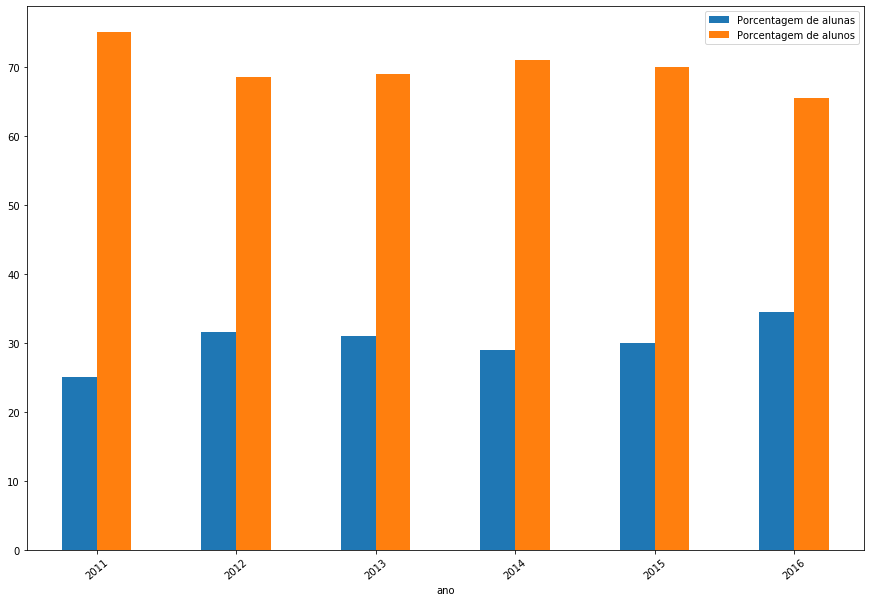

In [84]:
Jp = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "Japan"]

Jp2011 = Jp[Jp["year"] == 2011]
JpAlunas2011 = Jp2011['Porcentagem de alunas'].median()
JpAlunos2011 = Jp2011['Porcentagem de alunos'].median()

Jp2012 = Jp[Jp["year"] == 2012]
JpAlunas2012 = Jp2012['Porcentagem de alunas'].median()
JpAlunos2012 = Jp2012['Porcentagem de alunos'].median()

Jp2013 = Jp[Jp["year"] == 2013]
JpAlunas2013 = Jp2013['Porcentagem de alunas'].median()
JpAlunos2013 = Jp2013['Porcentagem de alunos'].median()

Jp2014 = Jp[Jp["year"] == 2014]
JpAlunas2014 = Jp2014['Porcentagem de alunas'].median()
JpAlunos2014 = Jp2014['Porcentagem de alunos'].median()

Jp2015 = Jp[Jp["year"] == 2015]
JpAlunas2015 = Jp2015['Porcentagem de alunas'].median()
JpAlunos2015 = Jp2015['Porcentagem de alunos'].median()

Jp2016 = Jp[Jp["year"] == 2016]
JpAlunas2016 = Jp2016['Porcentagem de alunas'].median()
JpAlunos2016 = Jp2016['Porcentagem de alunos'].median()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [JpAlunas2011, JpAlunas2012, JpAlunas2013, JpAlunas2014, JpAlunas2015, JpAlunas2016], 
     'Porcentagem de alunos' : [JpAlunos2011, JpAlunos2012, JpAlunos2013, JpAlunos2014, JpAlunos2015, JpAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

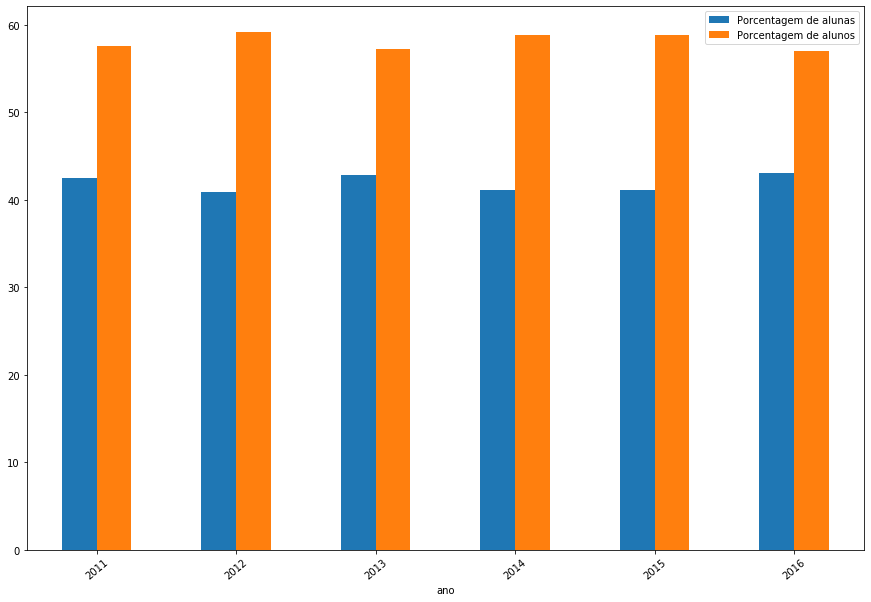

In [134]:
Ch = ComQuantidadeAlunos[ComQuantidadeAlunos["country"] == "China"]

Ch2011 = Ch[Ch["year"] == 2011]
ChAlunas2011 = Ch2011['Porcentagem de alunas'].mean()
ChAlunos2011 = Ch2011['Porcentagem de alunos'].mean()

Ch2012 = Ch[Ch["year"] == 2012]
ChAlunas2012 = Ch2012['Porcentagem de alunas'].mean()
ChAlunos2012 = Ch2012['Porcentagem de alunos'].mean()

Ch2013 = Ch[Ch["year"] == 2013]
ChAlunas2013 = Ch2013['Porcentagem de alunas'].mean()
ChAlunos2013 = Ch2013['Porcentagem de alunos'].mean()

Ch2014 = Ch[Ch["year"] == 2014]
ChAlunas2014 = Ch2014['Porcentagem de alunas'].mean()
ChAlunos2014 = Ch2014['Porcentagem de alunos'].mean()

Ch2015 = Ch[Ch["year"] == 2015]
ChAlunas2015 = Ch2015['Porcentagem de alunas'].mean()
ChAlunos2015 = Ch2015['Porcentagem de alunos'].mean()

Ch2016 = Ch[Ch["year"] == 2016]
ChAlunas2016 = Ch2016['Porcentagem de alunas'].mean()
ChAlunos2016 = Ch2016['Porcentagem de alunos'].mean()

d = {'ano': [2011, 2012, 2013, 2014, 2015, 2016], 
     'Porcentagem de alunas': [ChAlunas2011, ChAlunas2012, ChAlunas2013, ChAlunas2014, ChAlunas2015, ChAlunas2016], 
     'Porcentagem de alunos' : [ChAlunos2011, ChAlunos2012, ChAlunos2013, ChAlunos2014, ChAlunos2015, ChAlunos2016]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'ano', y = ['Porcentagem de alunas', 'Porcentagem de alunos'], rot = 40, figsize=(15,10))

### Pergunta 3.1

Universidades com pelo menos 50% de mulheres tem mais pontuação do que as que tem menos do que 50% de mulheres

In [150]:
MaisMulheres = ComQuantidadeAlunos[ComQuantidadeAlunos['Porcentagem de alunas'] >= 50]
MenosMulheres = ComQuantidadeAlunos[ComQuantidadeAlunos['Porcentagem de alunas'] < 50]

MaisMulheres = MaisMulheres['total_score'] 
MenosMulheres = MenosMulheres['total_score'] 


Mais = MaisMulheres.mean()
Menos = MenosMulheres.mean()

Mais,Menos

(44.379115853658554, 45.313029411764624)

In [151]:
Us = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'United States of America']
MaisMulheresUs = Us[Us['Porcentagem de alunas'] >= 50]
MenosMulheresUs = Us[Us['Porcentagem de alunas'] < 50]
MaisMulheresUs = MaisMulheresUs['total_score'] 
MenosMulheresUs = MenosMulheresUs['total_score'] 
MaisUs = MaisMulheresUs.mean()
MenosUs = MenosMulheresUs.mean()
MaisUs,MenosUs

(50.20454074585635, 57.95536480686695)

In [159]:
Pt = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Portugal']
MaisMulheresPt = Pt[Pt['Porcentagem de alunas'] >= 50]
MenosMulheresPt = Pt[Pt['Porcentagem de alunas'] < 50]
MaisMulheresPt = MaisMulheresPt['total_score'] 
MenosMulheresPt = MenosMulheresPt['total_score'] 
MaisPt = MaisMulheresPt.mean()
MenosPt = MenosMulheresPt.mean()
MaisPt,MenosPt

(30.37333333333333, 29.5)

In [160]:
Br = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Brazil']
MaisMulheresBr = Br[Br['Porcentagem de alunas'] >= 50]
MenosMulheresBr = Br[Br['Porcentagem de alunas'] < 50]
MaisMulheresBr = MaisMulheresBr['total_score'] 
MenosMulheresBr = MenosMulheresBr['total_score'] 
MaisBr = MaisMulheresBr.mean()
MenosBr = MenosMulheresBr.mean()
MaisBr,MenosBr

(20.440624999999997, 33.309999999999995)

In [161]:
Ca = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Canada']
MaisMulheresCa = Ca[Ca['Porcentagem de alunas'] >= 50]
MenosMulheresCa = Ca[Ca['Porcentagem de alunas'] < 50]
MaisMulheresCa = MaisMulheresCa['total_score'] 
MenosMulheresCa = MenosMulheresCa['total_score'] 
MaisCa = MaisMulheresCa.mean()
MenosCa = MenosMulheresCa.mean()
MaisCa,MenosCa

(47.1349431818182, 40.11500000000001)

In [162]:
Ge = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Germany']
MaisMulheresGe = Ge[Ge['Porcentagem de alunas'] >= 50]
MenosMulheresGe = Ge[Ge['Porcentagem de alunas'] < 50]
MaisMulheresGe = MaisMulheresGe['total_score'] 
MenosMulheresGe = MenosMulheresGe['total_score'] 
MaisGe = MaisMulheresGe.mean()
MenosGe = MenosMulheresGe.mean()
MaisGe,MenosGe

(49.51802325581396, 43.078448275862065)

In [164]:
Au = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Australia']
MaisMulheresAu = Au[Au['Porcentagem de alunas'] >= 50]
MenosMulheresAu = Au[Au['Porcentagem de alunas'] < 50]
MaisMulheresAu = MaisMulheresAu['total_score'] 
MenosMulheresAu = MenosMulheresAu['total_score'] 
MaisAu = MaisMulheresAu.mean()
MenosAu = MenosMulheresAu.mean()
MaisAu,MenosAu

(44.03979591836732, 45.57058823529412)

In [152]:
Jp = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'Japan']
MaisMulheresJp = Jp[Jp['Porcentagem de alunas'] >= 50]
MenosMulheresJp = Jp[Jp['Porcentagem de alunas'] < 50]
MaisMulheresJp = MaisMulheresJp['total_score'] 
MenosMulheresJp = MenosMulheresJp['total_score'] 
MaisJp = MaisMulheresJp.mean()
MenosJp = MenosMulheresJp.mean()
MaisJp,MenosJp

(29.268749999999997, 33.68799999999999)

In [153]:
Ch = ComQuantidadeAlunos[ComQuantidadeAlunos['country'] == 'China']
MaisMulheresCh = Ch[Ch['Porcentagem de alunas'] >= 50]
MenosMulheresCh = Ch[Ch['Porcentagem de alunas'] < 50]
MaisMulheresCh = MaisMulheresCh['total_score'] 
MenosMulheresCh = MenosMulheresCh['total_score'] 
MaisCh = MaisMulheresCh.mean()
MenosCh = MenosMulheresCh.mean()
MaisCh,MenosCh

(34.484375, 34.86428571428572)

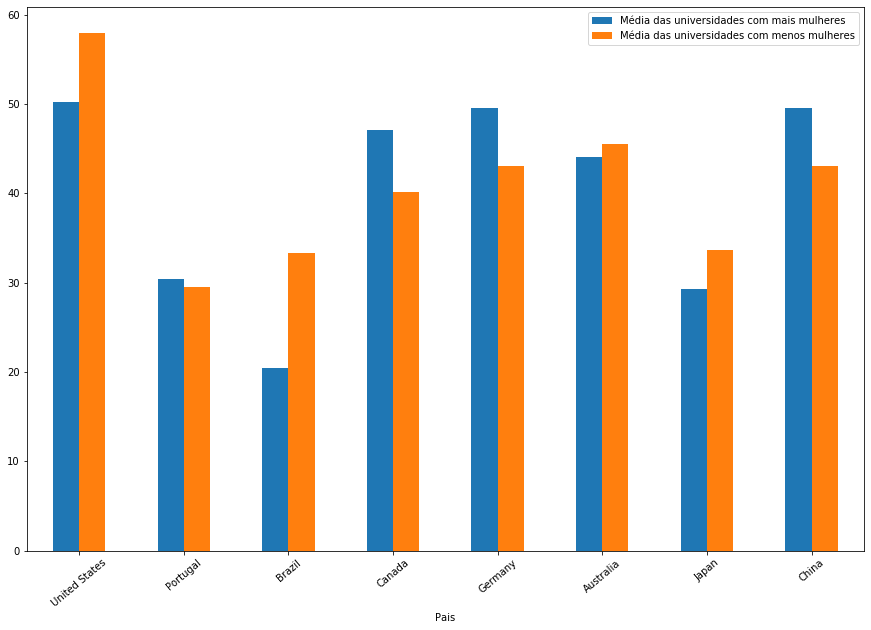

In [167]:
d = {'Pais': ['United States', 'Portugal', 'Brazil', 'Canada', 'Germany', 'Australia','Japan','China'], 
     'Média das universidades com mais mulheres': [MaisUs, MaisPt, MaisBr, MaisCa, MaisGe, MaisAu, MaisJp, MaisCh], 
     'Média das universidades com menos mulheres' : [MenosUs, MenosPt, MenosBr, MenosCa, MenosGe, MenosAu, MenosJp, MenosCh]}

df = pd.DataFrame(data=d)

df


df.plot.bar(x = 'Pais', y = ['Média das universidades com mais mulheres', 'Média das universidades com menos mulheres'], rot = 40, figsize=(15,10))

### Exploração dos dados

Com os dados tratados podemos começar a analisar

## Previsão

(uma ou duas subseções dependendo dos modelos utilizados)

## Conclusões